In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
abstracts = pd.read_csv('../data/save.csv', index_col=0)

C:\Users\Kaddi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
abstracts.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts
0,Quality of life in hypoparathyroidism.\r\n\r\n...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...
1,Vitamin D status and its association with seas...,30261231,2018.0,Neurosci Lett,Vitamin D status and its association with seas...,GuY ZhuZ LuanX HeJ,HeJ,1.0,0.0,BACKGROUND: Vitamin D plays a key role in depr...
2,Tenofovir disoproxil fumarate appears to disru...,30260797,2018.0,Antivir Ther,Tenofovir disoproxil fumarate appears to disru...,HavensPL LongD SchusterGU GordonCM PriceG Wils...,StephensenCB,0.0,0.0,BACKGROUND: Tenofovir disoproxil fumarate (TDF...
3,"Vitamin D Levels in Active TB, Latent TB, Non-...",30260729,2018.0,Fetal Pediatr Pathol,Vitamin D Levels in Active TB Latent TB Non-TB...,BuonsensoD SaliM PataD MasielloE SalernoG Cecc...,ValentiniP,0.0,0.0,BACKGROUND: Growing evidence suggests that vit...
4,Vitamin D receptor interacts with NLRP3 to res...,30260469,2018.0,Clin Exp Immunol,Vitamin D receptor interacts with NLRP3 to res...,HuangH HongJY WuYJ WangEY LiuZQ ChengBH MeiL L...,ZhengPY,0.0,0.0,Vitamin D receptor (VDR) mediates various bioc...


### removing short abstracts
- very old abstracts (from the beginning of the 20th century) are only indexed and do not contain an abstract, just a title and authors
    - have no valuable information
    - can be cut by removing abstracts that don't meet a certain length
- the column with the abstract lengths is dropped at the end because it is not needed anymore

In [5]:
abstracts['abstract_length'] = abstracts.abstract.str.len()

In [6]:
abstracts_length = abstracts.sort_values('abstract_length', ascending=False)

In [7]:
abstracts_length.describe()

,year,blood,dosage,abstract_length
count,66238.000000,66240.000000,66240.000000,66240.000000
mean,2002.565899,0.095864,0.065082,1697.220939
std,14.725192,0.294406,0.246672,914.118073
min,1922.000000,0.000000,0.000000,18.000000
25%,1994.000000,0.000000,0.000000,1184.000000
50%,2008.000000,0.000000,0.000000,1815.000000
75%,2014.000000,0.000000,0.000000,2234.000000
max,2018.000000,1.000000,1.000000,15214.000000


The minimum length of abstract is 68 characters, the maximum is 15076 characters.

In [8]:
abstracts_length.head(15)

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts,abstract_length
2619,"Genome-wide association study in 79,366 Europe...",29343764,2018.0,Nat Commun,Genome-wide association study in 79366 Europea...,JiangX O'ReillyPF AschardH HsuYH RichardsJB Du...,KielDP,0.0,0.0,Author information: \r\n(1)Program in Genetic ...,15214
16188,Association of vitamin D status with arterial ...,24974252,2014.0,Lancet Diabetes Endocrinol,Association of vitamin D status with arterial ...,VimaleswaranKS CavadinoA BerryDJ,BerryDJ,0.0,0.0,"Author information: \r\n(1)Population, Policy ...",14919
8037,Association of vitamin D levels and risk of ov...,27594614,2016.0,Int J Epidemiol,Association of vitamin D levels and risk of ov...,OngJS Cuellar-PartidaG LuY,LuY,1.0,0.0,Author information: \r\n(1)Statistical Genetic...,12532
9758,Genetic Evidence for Causal Relationships Betw...,26978208,2016.0,JAMA,Genetic Evidence for Causal Relationships Betw...,TyrrellJ RichmondRC PalmerTM FeenstraB Rangara...,FreathyRM,0.0,0.0,Author information: \r\n(1)Institute of Biomed...,11651
33887,Prevention of falls and fall-related injuries ...,23074507,2008.0,Ont Health Technol Assess Ser,Prevention of falls and fall-related injuries ...,HealthQualityOntario,HealthQualityOntario,0.0,0.0,"In early August 2007, the Medical Advisory Sec...",10347
30128,Overview of the epidemiology methods and appli...,21132580,2010.0,Crit Rev Food Sci Nutr,Overview of the epidemiology methods and appli...,ColditzGA,ColditzGA,0.0,0.0,The impact of study design on the results of m...,10302
4422,Low-Frequency Synonymous Coding Variation in C...,28757204,2017.0,Am J Hum Genet,Low-Frequency Synonymous Coding Variation in C...,ManousakiD DuddingT HaworthS HsuYH LiuCT Medin...,RichardsJB,0.0,0.0,Author information: \r\n(1)Department of Human...,10259
30110,Clinical utility of vitamin d testing: an evid...,23074397,2010.0,Ont Health Technol Assess Ser,Clinical utility of vitamin d testing: an evid...,HealthQualityOntario,HealthQualityOntario,1.0,1.0,This report from the Medical Advisory Secretar...,10226
38464,Osteogenic protein-1 for long bone nonunion: a...,23074475,2005.0,Ont Health Technol Assess Ser,Osteogenic protein-1 for long bone nonunion: a...,HealthQualityOntario,HealthQualityOntario,0.0,1.0,OBJECTIVE: To assess the efficacy of osteogeni...,10198
15390,Robotic total thyroidectomy with modified radi...,25227305,2014.0,Ann Surg Oncol,Robotic total thyroidectomy with modified radi...,ByeonHK HolsingerFC TufanoRP ChungHJ KimWS Koh...,ChoiEC,1.0,1.0,"BACKGROUND: Traditionally, total thyroidectomy...",10133


A few abstracts are really long and are checked if they are properly split.

In [9]:
print(abstracts_length.iloc[0,0])

Genome-wide association study in 79,366 European-ancestry individuals informs the
genetic architecture of 25-hydroxyvitamin D levels.

Jiang X(1)(2), O'Reilly PF(3), Aschard H(1)(4), Hsu YH(5)(6)(7), Richards JB(8), 
Dupuis J(9)(10), Ingelsson E(11)(12), Karasik D(5), Pilz S(13), Berry D(14),
Kestenbaum B(15), Zheng J(16), Luan J(16), Sofianopoulou E(17), Streeten EA(18), 
Albanes D(19), Lutsey PL(20), Yao L(20), Tang W(20), Econs MJ(21), Wallaschofski 
H(22)(23), VÃ¶lzke H(23)(24), Zhou A(25), Power C(14), McCarthy MI(26)(27)(28),
Michos ED(29)(30), Boerwinkle E(31), Weinstein SJ(19), Freedman ND(19), Huang
WY(32), Van Schoor NM(33), van der Velde N(34)(35), Groot LCPGM(36), Enneman
A(34), Cupples LA(9)(10), Booth SL(37), Vasan RS(10), Liu CT(9), Zhou Y(9),
Ripatti S(38), Ohlsson C(39), Vandenput L(39), Lorentzon M(40), Eriksson
JG(41)(42), Shea MK(37), Houston DK(43), Kritchevsky SB(43), Liu Y(44), Lohman
KK(45), Ferrucci L(46), Peacock M(21), Gieger C(47), Beekman M(48), Slagboom
E(

The abstracts are so extremely long because a lot of authors are part of the study and all of them and their universities are listes. The split worked properly.

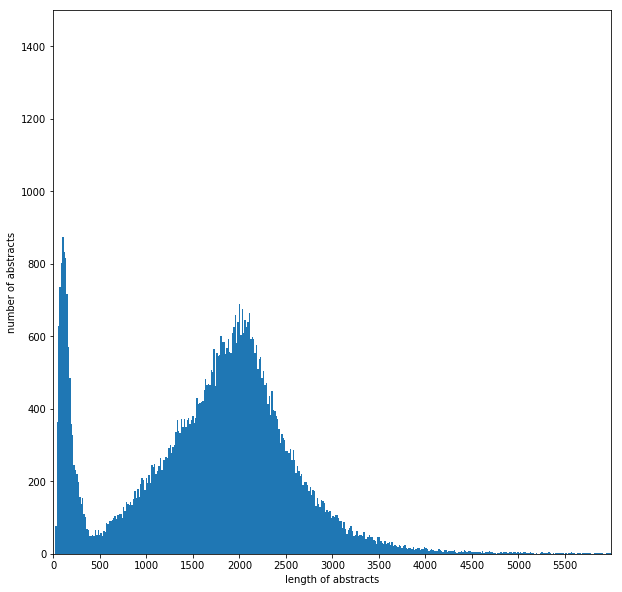

In [10]:
plt.figure(figsize=(10,10))
plt.hist(abstracts['abstract_length'], bins=1000)
plt.xlabel('length of abstracts')
plt.ylabel('number of abstracts')
plt.xlim(0,6000)
plt.ylim(0,1500)
plt.xticks(np.arange(0, 6000, 500.0))
plt.show()

There are so many extremely short abstracts that a big peak is obvious. This peak needs to be removed. Cut-off is set at a minimum length of 500 characters.
The really long abstracts were cut-off in this graph to have a better visualisation of the peaks.

In [11]:
abstracts = abstracts[abstracts['abstract_length'] > 500]

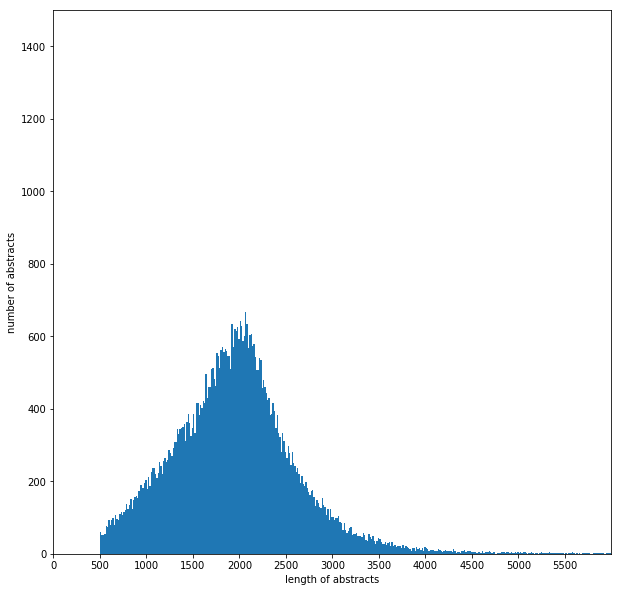

In [12]:
plt.figure(figsize=(10,10))
plt.hist(abstracts['abstract_length'], bins=1000)
plt.xlabel('length of abstracts')
plt.ylabel('number of abstracts')
plt.xlim(0,6000)
plt.ylim(0,1500)
plt.xticks(np.arange(0, 6000, 500.0))
plt.show()

In [13]:
abstracts.drop('abstract_length', axis=1, inplace=True)

### Formatting the abstracts
- the numbering is removed
- the new lines are removed

In [14]:
# remove numbering (for details see file 'text_to_dataframe')
abstracts['abstract'] = abstracts['abstract'].str.replace('(\n+\d+\.)', '')

# whitespaces in the beginning are stripped
abstracts['abstract'] = abstracts['abstract'].str.lstrip()

In [15]:
abstracts['abstract'] = abstracts['abstract'].str.replace('\n+', ' ')
abstracts['abstract'] = abstracts['abstract'].str.replace('\s+', ' ')

### Getting only the abstracts that contain signifi*
- signifi* = significance, significant, significantly
- since significa* can start with a capital letter, all letters are made lower case
- every row with the abstract containing a variation of signifi* is pulled
- abstracts that just contain "significance:" as to explain the significance of the paper and not the results are removed

In [17]:
abstracts['abstract'] = abstracts['abstract'].str.lower()

In [18]:
unused_abstracts = abstracts[abstracts.abstract.str.contains('signifi\D+') == False]
print(f'Abstract that do not talk about (non-)significant results: {len(unused_abstracts)}')

Abstract that do not talk about (non-)significant results: 32708


In [19]:
abstracts = abstracts[abstracts.abstract.str.contains('signifi\D+') == True]
print(f'Number of abstracts: {len(abstracts)}')

Number of abstracts: 23844


In [20]:
abstracts = abstracts[abstracts.abstract.str.contains('significance:') == False]
print(f'Remaining abstracts: {len(abstracts)}')

Remaining abstracts: 23744


### Labelling the abstracts
- possible labels for 'significant' are: 'yes', 'no', 'both'
- filters are used to label as many abstracts as possible
    - abstracts containing no/not/non-signifi* are labelled as 'no'
    - unlabelled abstracts are checked by hand to generate the filter for 'yes' and improve the filter for 'no'
    - filter for 'yes' and 'no' are combined to gererate filter for 'both'
- the labelled data will be used to train a model, to predict the labels for the unlabelled data

In [21]:
def label_significance(df, *,column):
    df['significant'] = np.zeros((len(df), 1))
    
    no = r'no signifi|not signifi|non-signifi|did not vary signifi|any signifi|not statistically signifi\
    |without signifi'
    df['significant'][df[column].str.contains(no)] = 'no'
    
    yes = r'were signific|a signifi|was signifi|highly signifi|very signifi|significantly \D+ed\
    |more signifi|most signifi|less signifi|\D+ed signifi\D+|direct signifi|signifi\D+ associat\D+|\D+s signifi\
    |had signifi|significantly \D+s|\D+s signifi'
    df['significant'][df[column].str.contains(yes)] = 'yes'
    
    df['significant'][(df[column].str.contains(yes)) & (df[column].str.contains(no))] = 'both'
    
    return df

In [22]:
abstracts_labelled = label_significance(abstracts, column='abstract')

### Result of by-hand labelling

In [23]:
count = abstracts_labelled.groupby('significant').count()
count

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts
significant,,,,,,,,,,
0.0,2993,2993,2993,2992,2993,2989,2989,2993,2993,2993
both,4090,4090,4090,4090,4090,4090,4090,4090,4090,4090
no,1574,1574,1574,1574,1574,1574,1574,1574,1574,1574
yes,15087,15087,15086,15087,15087,15086,15086,15087,15087,15087


In [24]:
print(f'{len(abstracts_labelled)-count.iloc[0,0]} abstracts ({np.round((len(abstracts_labelled)-count.iloc[0,0])/\
len(abstracts_labelled)*100)} %) could successfully be labelled succesfully')
print(f'{count.iloc[0,0]} abstracts ({np.round(count.iloc[0,0]/len(abstracts_labelled)*100)} %) could not be labelled')

20751 abstracts (87.0 %) could successfully be labelled succesfully
2993 abstracts (13.0 %) could not be labelled


In [25]:
abstracts.head()

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts,significant
0,quality of life in hypoparathyroidism. vokes t...,30261328,2018.0,Bone,Quality of life in hypoparathyroidism,VokesT,VokesT,0.0,0.0,Hypoparathyroidism is a rare endocrine disorde...,0
1,vitamin d status and its association with seas...,30261231,2018.0,Neurosci Lett,Vitamin D status and its association with seas...,GuY ZhuZ LuanX HeJ,HeJ,1.0,0.0,BACKGROUND: Vitamin D plays a key role in depr...,yes
3,"vitamin d levels in active tb, latent tb, non-...",30260729,2018.0,Fetal Pediatr Pathol,Vitamin D Levels in Active TB Latent TB Non-TB...,BuonsensoD SaliM PataD MasielloE SalernoG Cecc...,ValentiniP,0.0,0.0,BACKGROUND: Growing evidence suggests that vit...,yes
6,correlation of vitamin d binding protein gene ...,30259785,2018.0,Per Med,Correlation of vitamin D binding protein gene ...,ChuaychooB TungtrongchitrR KriengsinyosW Tunti...,ChupeerachC,0.0,0.0,AIM: The risk of vitamin D binding protein (DB...,both
7,vitamin d status including 3-epi-25(oh)d3 amon...,30259504,2018.0,Endokrynol Pol,Vitamin D status including 3-epi-25OHD3 among ...,KmieÄP MinkiewiczI SworczakK Å»mijewskiMA Kow...,KowalskiK,1.0,0.0,INTRODUCTION: In the context of pleiotropic vi...,yes


# Saving the data to csv

In [26]:
abstracts.to_csv('../data/labelled_save.csv')
unused_abstracts.to_csv('../data/no_signi_abstracts.csv')

# Breast cancer as an example

In [27]:
breast_cancer = abstracts_labelled[abstracts_labelled.abstract.str.contains('breast cancer|mammary carcinoma') == True]

In [28]:
count = breast_cancer.groupby('significant').count()
count

,abstract,PMID,year,journal,title,author,prof,blood,dosage,clean_abstracts
significant,,,,,,,,,,
0.0,77,77,77,77,77,77,77,77,77,77
both,89,89,89,89,89,89,89,89,89,89
no,34,34,34,34,34,34,34,34,34,34
yes,320,320,320,320,320,320,320,320,320,320


In [29]:
print(f'{len(breast_cancer)-count.iloc[0,0]} abstracts ({np.round((len(breast_cancer)-count.iloc[0,0])/\
len(breast_cancer)*100)} %) could successfully be labelled succesfully')
print(f'{count.iloc[0,0]} abstracts ({np.round(count.iloc[0,0]/len(breast_cancer)*100)} %) could not be labelled')

443 abstracts (85.0 %) could successfully be labelled succesfully
77 abstracts (15.0 %) could not be labelled
